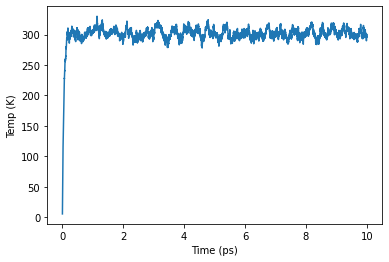

In [4]:
'''
Created on September 22, 2018
@author: Andrew Abi-Mansour
'''

# !/usr/bin/python
# -*- coding: utf8 -*-
# -------------------------------------------------------------------------
#
#   A simple molecular dynamics solver that simulates the motion
#   of non-interacting particles in the canonical ensemble using
#   a Langevin thermostat.
#
# --------------------------------------------------------------------------
#
#   This program is free software: you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation, either version 2 of the License, or
#   (at your option) any later version.

#   This program is distributed in the hope that it will be useful,
#   but WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#   GNU General Public License for more details.

#   You should have received a copy of the GNU General Public License
#   along with this program.  If not, see <http://www.gnu.org/licenses/>.

# -------------------------------------------------------------------------

import numpy as np
import matplotlib.pylab as plt
import dump

# Define global physical constants
Avogadro = 6.02214086e23
Boltzmann = 1.38064852e-23

def wallHitCheck(pos, vels, box):
    """ This function enforces reflective boundary conditions.
    All particles that hit a wall  have their velocity updated
    in the opposite direction.
    @pos: atomic positions (ndarray)
    @vels: atomic velocity (ndarray, updated if collisions detected)
    @box: simulation box size (tuple)
    """
    ndims = len(box)

    for i in range(ndims):
        vels[((pos[:,i] <= box[i][0]) | (pos[:,i] >= box[i][1])),i] *= -1

def integrate(pos, vels, forces, mass,  dt):
    """ A simple forward Euler integrator that moves the system in time 
    @pos: atomic positions (ndarray, updated)
    @vels: atomic velocity (ndarray, updated)
    """
    
    pos += vels * dt
    vels += forces * dt / mass[np.newaxis].T
    
def computeForce(mass, vels, temp, relax, dt):
    """ Computes the Langevin force for all particles
    @mass: particle mass (ndarray)
    @vels: particle velocities (ndarray)
    @temp: temperature (float)
    @relax: thermostat constant (float)
    @dt: simulation timestep (float)
    returns forces (ndarray)
    """

    natoms, ndims = vels.shape

    sigma = np.sqrt(2.0 * mass * temp * Boltzmann / (relax * dt))
    noise = np.random.randn(natoms, ndims) * sigma[np.newaxis].T

    force = - (vels * mass[np.newaxis].T) / relax + noise
    
    return force

def removeCOM(pos, mass):
    """ Removes center of mass motion. This function is not used. """
    pos -= np.dot(mass, pos) / mass.sum()

def run(**args):
    """ This is the main function that solves Langevin's equations for
    a system of natoms usinga forward Euler scheme, and returns an output
    list that stores the time and the temperture.
    
    @natoms (int): number of particles
    @temp (float): temperature (in Kelvin)
    @mass (float): particle mass (in Kg)
    @relax (float): relaxation constant (in seconds)
    @dt (float): simulation timestep (s)
    @nsteps (int): total number of steps the solver performs
    @box (tuple): simulation box size (in meters) of size dimensions x 2
    e.g. box = ((-1e-9, 1e-9), (-1e-9, 1e-9)) defines a 2D square
    @ofname (string): filename to write output to
    @freq (int): write output every 'freq' steps
    
    @[radius]: particle radius (for visualization)
    
    Returns a list (of size nsteps x 2) containing the time and temperature.
    
    """

    natoms, box, dt, temp = args['natoms'], args['box'], args['dt'], args['temp']
    mass, relax, nsteps   = args['mass'], args['relax'], args['steps']
    ofname, freq, radius = args['ofname'], args['freq'], args['radius']
    
    dim = len(box)
    pos = np.random.rand(natoms,dim)

    for i in range(dim):
        pos[:,i] = box[i][0] + (box[i][1] -  box[i][0]) * pos[:,i]

    vels = np.random.rand(natoms,dim)
    mass = np.ones(natoms) * mass / Avogadro
    radius = np.ones(natoms) * radius
    step = 0

    output = []

    while step <= nsteps:

        step += 1

        # Compute all forces
        forces = computeForce(mass, vels, temp, relax, dt)

        # Move the system in time
        integrate(pos, vels, forces, mass, dt)

        # Check if any particle has collided with the wall
        wallHitCheck(pos,vels,box)

        # Compute output (temperature)
        ins_temp = np.sum(np.dot(mass, (vels - vels.mean(axis=0))**2)) / (Boltzmann * dim * natoms)
        output.append([step * dt, ins_temp])
        
        if not step%freq:
            dump.writeOutput(ofname, natoms, step, box, radius=radius, pos=pos, v=vels)

    return np.array(output)

if __name__ == '__main__':

    params = {
        'natoms': 1000,
        'temp': 300,
        'mass': 0.001,
        'radius': 120e-12,
        'relax': 1e-13,
        'dt': 1e-15,
        'steps': 10000,
        'freq': 100,
        'box': ((0, 1e-8), (0, 1e-8), (0, 1e-8)),
        'ofname': 'traj-hydrogen-3D.dump'
        }

    output = run(**params)

    plt.plot(output[:,0] * 1e12, output[:,1])
    plt.xlabel('Time (ps)')
    plt.ylabel('Temp (K)')
    plt.show()